Code to plot points using the deep-learning model and mean-variance model

In [ ]:
import numpy as np

# setting the seed allows for reproducible results
np.random.seed(123)

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

import pandas as pd
import matplotlib.pyplot as plt
import math

In [ ]:
import cvxopt
from cvxopt import matrix, solvers

In [ ]:
class Model:
    def __init__(self):
        self.data = None
        self.model = None
        self.final_ratio = None

    def sharpe_loss(self, _, y_pred):
        # make all time-series start at 1
        data = tf.divide(self.data, self.data[0])

        # value of the portfolio after allocations applied
        portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1)

        portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

        sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)

        return -sharpe

    def __build_model(self, input_shape, outputs, l_rate):

        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        Opt = Adam(learning_rate = l_rate)
        model.compile(loss=self.sharpe_loss, optimizer=Opt)
        return model

    def get_allocations(self, data: pd.DataFrame, lr=0.001, ep=20):

        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)

        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)

        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns), l_rate = lr)

        fit_predict_data = data_w_ret[np.newaxis,:]
        history = self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=ep, shuffle=False)
        self.final_ratio = -history.history['loss'][-1]

        return self.model.predict(fit_predict_data)[0]

Upload a csv file containing the data of assets. The data should be in the format such that it contains price of the asset on given date.
If there are n companies and k days of data, then it should have k rows and n columns.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/OMF_data_final/uploaded_data_2/Dataset_2_csv.csv')

In [ ]:
df = df[df.columns[1:]]

In [ ]:
window = 30
num_days = len(df.index)
num_companies = df.columns.size
total_rows = num_days - window + 1

In [ ]:
num_epochs = 10 # Change it to number of epochs needed
T = []
learning_rates = []

In [ ]:
model_return = []
model_risk = []
mkw_return = []
mkw_risk = []

In [ ]:
lr = 0.1 # Put the learning rate required

In [ ]:
for itr in range(total_rows):
  tempdf = df.iloc[itr:itr+window]
  temparr = tempdf.to_numpy()
  return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]
  exp_return = np.mean(return_rate,axis=0)
  temp_cov = np.transpose(return_rate) @ return_rate
  temp_cov = temp_cov/(window-1)

  m = Model()
  w = m.get_allocations(tempdf,lr,num_epochs)
  model_return.append(np.dot(w,exp_return))
  temp_model_risk = np.transpose(w) @ temp_cov @ w
  temp_model_risk = math.sqrt(temp_model_risk)
  model_risk.append(temp_model_risk)

In [ ]:
for itr in range(total_rows):
  tempdf = df.iloc[itr:itr+window]
  temparr = tempdf.to_numpy()
  return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]
  exp_return = np.mean(return_rate,axis=0)
  temp_cov = np.transpose(return_rate) @ return_rate
  temp_cov = temp_cov/(window-1)

  e = np.ones(num_companies)

  R = model_return[itr]

  P = matrix(2*temp_cov)
  q = matrix(np.zeros(num_companies))

  A = matrix(np.array([e, exp_return]))
  b = matrix(np.array([1,R]))

  G = matrix(-np.eye(num_companies))
  h = matrix(np.zeros(num_companies))
  sol = solvers.qp(P, q, G=G, h=h, A=A, b=b)

  wmw = np.array(sol['x'])
  mkw_return.append(R)
  mkw_risk.append(math.sqrt(sol['primal objective']))

In [ ]:
tsum = 0
for i in range(len(model_return)):
  tval = (model_risk[i] - mkw_risk[i])/abs(model_return[i])
  tsum += tval

tsum /= len(model_return)
# tsum stores the value of the learning rate's comparision parameter
T.append(tsum)
learning_rates.append(lr)

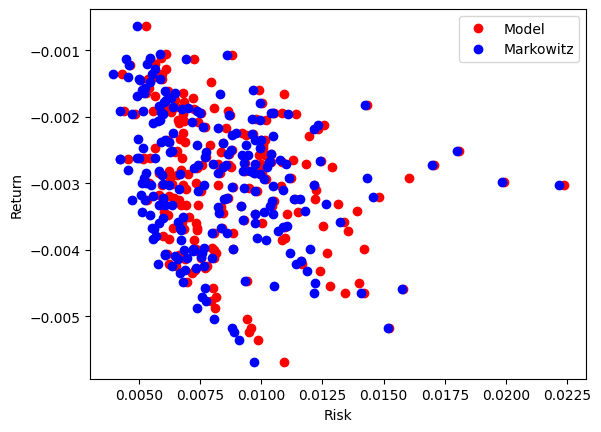

In [ ]:
plt.plot(model_risk,model_return,'o',color='r',label='Model')
plt.plot(mkw_risk, mkw_return,'o',color='b',label='Markowitz')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.legend()
plt.show()

In [ ]:
# T

In [ ]:
# learning_rates